Importamos los módulos y librerías necesarias, y definimos nuestras funciones junto con los modelos a entrenar

In [1]:
import pandas as pd  
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statistics
import sklearn
import time

from IPython.core.interactiveshell import InteractiveShell

from IPython.display import display
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, auc, roc_curve, f1_score
from sklearn.decomposition import PCA
from sklearn import model_selection
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

InteractiveShell.ast_node_interactivity = "all"

models = []
models.append(('LR', LogisticRegression(max_iter=1000)))
models.append(('KNN9', KNeighborsClassifier(n_neighbors=9)))
models.append(('KNN7', KNeighborsClassifier(n_neighbors=7)))
models.append(('KNN5', KNeighborsClassifier()))
models.append(('KNN3', KNeighborsClassifier(n_neighbors=3)))
models.append(('KNN1', KNeighborsClassifier(n_neighbors=1)))
models.append(('RF', RandomForestClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
models.append(('MLP', MLPClassifier()))

features = []
trained_models = []

# Leemos los ficheros CSV con las muestras benignas y malignas
pd_b = pd.read_csv("./dataset_benign.csv")
pd_m = pd.read_csv("./dataset_malware.csv")

# Función para obtener aquellas características donde su desviación típica es 0
# en el dataset benignno o en el maligno
def getColumnsZeroStd():
    global pd_b     # Variable global de dataset benigno
    global pd_m     # Variable global de dataset maligno

    benign = pd_b
    malware = pd_m

    pd.set_option('display.max_columns', 10)

    drop = ['Name', 'Malware']
    
    b = benign.drop(['Name', 'Malware'], axis=1)
    m = malware.drop(['Name', 'Malware'], axis=1)
    for feature in b.columns:
        # print(feature)
        if b[feature].std() == 0:
            drop.append(feature)
    for feature in m.columns:
        # print(feature)
        if m[feature].std() == 0:
            if feature not in drop:
                drop.append(feature)

    print(drop)
    print(len(drop))

    return drop

# Función para crear el conjunto de datos a partir de los dos datasets y el
# balanceo que deseemos aplicar 
def buildDataset(resample="", drop=['Name', 'Malware']):
    global pd_b
    global pd_m

    benign = pd_b
    malware = pd_m

    data = pd.concat([benign, malware], ignore_index=True)

    X = data.drop(drop, axis=1)
    y = data['Malware']

    if (resample == "-o"):
        print("Aplicando oversampling...")
        smote = SMOTE(random_state=42)
        X, y = smote.fit_resample(X, y)
    elif (resample == "-u"):
        print("\n\n\nAplicando undersampling...")
        nearmiss = NearMiss(version=1)
        X, y = nearmiss.fit_resample(X, y)

    pd.set_option('display.max_columns', None)
    display(X)
    print("Número de muestras totales:", len(X), "\n\n\n")
    return X, y


# Estandarización de los datos y división del conjunto de datos en conjunto 
# de entrenamiento y test 
def trainTest(X, y):
    global features
    features = X.columns

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=101)

    sc = StandardScaler().fit(X_train)

    X_train = sc.transform(X_train)
    X_test = sc.transform(X_test)

    print(f'Número de características usadas: {X_train.shape[1]} \n\n\n')

    return X_train, X_test, y_train, y_test

# Entrenamiento de los modelos y realizar validación cruzada
def train_and_CV(X_train, y_train):
    results = []
    names = []
    scoring = 'accuracy'
    print("VALIDACIÓN CRUZADA")
    for name, model in models:
        kfold = model_selection.KFold(n_splits=5)
        inicio = time.time()
        trained_model = model.fit(X_train, y_train)
        fin = time.time()
        cv_results = model_selection.cross_val_score(
            trained_model, X_train, y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f) (%fs)" % (name, cv_results.mean(), cv_results.std(), (fin-inicio))
        print(msg)
        trained_models.append((name, trained_model))

    print("\n\n\n")

# Función para realizar la predicción de los modelos entrenados anteriormente
def compareMLAs(X_train, X_test, y_train, y_test):
    MLA_columns = []
    MLA_compare = pd.DataFrame(columns=MLA_columns)

    row_index = 0
    for name, model in trained_models:

        inicio = time.time()
        predicted = model.predict(X_test)
        fin=time.time()

        tn, fp, fn, tp  = confusion_matrix(y_test, predicted).ravel()

        MLA_name = name
        MLA_compare.loc[row_index, 'MLA used'] = MLA_name
        MLA_compare.loc[row_index, 'Train Accuracy'] = round(
            model.score(X_train, y_train), 4)
        MLA_compare.loc[row_index, 'Test Accuracy'] = round(
            model.score(X_test, y_test), 4)
        MLA_compare.loc[row_index, 'Precision'] = round(precision_score(
            y_test, predicted), 4)
        MLA_compare.loc[row_index, 'Recall'] = round(recall_score(y_test, predicted),4)
        MLA_compare.loc[row_index, 'F1-Score'] = round(f1_score(
            y_test, predicted),4)
        MLA_compare.loc[row_index, 'Tiempo de ejecución'] = (fin-inicio)
        MLA_compare.loc[row_index, 'True negatives'] = tn
        MLA_compare.loc[row_index, 'False positives'] = fp
        MLA_compare.loc[row_index, 'False negatives'] = fn
        MLA_compare.loc[row_index, 'True positives'] = tp

        row_index += 1
        
    MLA_compare.sort_values(by=['Test Accuracy'],
                            ascending=False, inplace=True)
    display(MLA_compare)

Descripción de las muestras malignas y benignas

In [2]:
print("BENIGN")
display(pd_b.describe())
print("MALWARE")
display(pd_m.describe())

BENIGN


,e_magic,e_cblp,e_cp,e_crlc,e_cparhdr,e_minalloc,e_maxalloc,e_ss,e_sp,e_csum,...,SectionMaxChar,SectionMainChar,DirectoryEntryImport,DirectoryEntryImportSize,DirectoryEntryExport,ImageDirectoryEntryExport,ImageDirectoryEntryImport,ImageDirectoryEntryResource,ImageDirectoryEntryException,ImageDirectoryEntrySecurity
count,4114.0,4114.0,4114.0,4114.0,4114.0,4114.0,4114.0,4114.0,4114.0,4114.0,...,4.114000e+03,4114.0,4114.000000,4114.000000,4114.000000,4.114000e+03,4.114000e+03,4.114000e+03,4.114000e+03,4.114000e+03
mean,23117.0,144.0,3.0,0.0,4.0,0.0,65535.0,0.0,184.0,0.0,...,3.042402e+09,0.0,21.237968,146.267380,57.013369,3.845512e+05,4.075309e+05,4.677111e+05,4.419244e+05,2.286830e+05
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.563826e+08,0.0,16.639365,130.550541,476.280667,1.105411e+06,1.088006e+06,1.338685e+06,1.228953e+06,2.394781e+06
min,23117.0,144.0,3.0,0.0,4.0,0.0,65535.0,0.0,184.0,0.0,...,1.073742e+09,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,23117.0,144.0,3.0,0.0,4.0,0.0,65535.0,0.0,184.0,0.0,...,3.221226e+09,0.0,7.000000,66.000000,1.000000,1.326400e+04,3.498800e+04,4.915200e+04,4.505600e+04,0.000000e+00
50%,23117.0,144.0,3.0,0.0,4.0,0.0,65535.0,0.0,184.0,0.0,...,3.221226e+09,0.0,19.000000,120.000000,3.000000,9.201600e+04,1.136880e+05,1.351680e+05,1.310720e+05,0.000000e+00
75%,23117.0,144.0,3.0,0.0,4.0,0.0,65535.0,0.0,184.0,0.0,...,3.221226e+09,0.0,32.000000,194.000000,7.000000,3.240080e+05,3.547080e+05,3.973120e+05,3.809280e+05,0.000000e+00
max,23117.0,144.0,3.0,0.0,4.0,0.0,65535.0,0.0,184.0,0.0,...,3.791651e+09,0.0,101.000000,2084.000000,9331.000000,2.418946e+07,2.419063e+07,3.218227e+07,3.212083e+07,1.425613e+08


MALWARE


,e_magic,e_cblp,e_cp,e_crlc,e_cparhdr,e_minalloc,e_maxalloc,e_ss,e_sp,e_csum,...,SectionMaxChar,SectionMainChar,DirectoryEntryImport,DirectoryEntryImportSize,DirectoryEntryExport,ImageDirectoryEntryExport,ImageDirectoryEntryImport,ImageDirectoryEntryResource,ImageDirectoryEntryException,ImageDirectoryEntrySecurity
count,87061.0,87061.000000,87061.000000,87061.000000,87061.000000,87061.000000,87061.000000,87061.000000,87061.000000,87061.000000,...,8.706100e+04,87061.0,87061.000000,87061.000000,87061.000000,8.706100e+04,8.706100e+04,8.706100e+04,8.706100e+04,8.706100e+04
mean,23117.0,410.199446,328.580432,259.449512,206.039409,251.417569,63181.197138,131.052917,518.352523,183.797717,...,3.419790e+09,0.0,5.285857,77.203788,2.831245,5.827229e+05,7.237835e+05,5.897180e+05,8.924233e+06,5.901234e+05
std,0.0,2578.268582,2886.986401,2441.438010,2042.891389,2354.894371,10584.525240,2772.624947,3343.579355,2260.183198,...,3.762867e+08,0.0,6.316504,111.263361,56.464660,3.808776e+07,2.871895e+07,2.246723e+07,1.604676e+08,3.456657e+07
min,23117.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,23117.0,80.000000,2.000000,0.000000,4.000000,0.000000,65535.000000,0.000000,184.000000,0.000000,...,3.221226e+09,0.0,1.000000,7.000000,0.000000,0.000000e+00,3.022400e+04,1.638400e+04,0.000000e+00,0.000000e+00
50%,23117.0,144.000000,3.000000,0.000000,4.000000,0.000000,65535.000000,0.000000,184.000000,0.000000,...,3.221226e+09,0.0,4.000000,30.000000,0.000000,0.000000e+00,8.758800e+04,8.601600e+04,0.000000e+00,0.000000e+00
75%,23117.0,144.000000,3.000000,0.000000,4.000000,0.000000,65535.000000,0.000000,184.000000,0.000000,...,3.758096e+09,0.0,8.000000,103.000000,0.000000,0.000000e+00,3.235840e+05,2.867200e+05,0.000000e+00,0.000000e+00
max,23117.0,65526.000000,65532.000000,65535.000000,64419.000000,65535.000000,65535.000000,65528.000000,65535.000000,63703.000000,...,4.278197e+09,0.0,589.000000,1869.000000,4657.000000,4.290825e+09,4.140021e+09,3.604350e+09,3.857049e+09,4.175626e+09


Obtenemos las columnas con std=0

In [3]:
drop = getColumnsZeroStd()

['Name', 'Malware', 'e_magic', 'e_cblp', 'e_cp', 'e_crlc', 'e_cparhdr', 'e_minalloc', 'e_maxalloc', 'e_ss', 'e_sp', 'e_csum', 'e_ip', 'e_cs', 'e_lfarlc', 'e_ovno', 'PointerToSymbolTable', 'NumberOfSymbols', 'LoaderFlags', 'NumberOfRvaAndSizes', 'SuspiciousNameSection', 'SectionMaxEntropy', 'SectionMaxRawsize', 'SectionMaxVirtualsize', 'SectionMinPhysical', 'SectionMinVirtual', 'SectionMinPointerData', 'SectionMainChar']
28


Construimos el conjunto de datos para obtener la matriz de correlaciones sin las características con std=0

In [4]:
X,y = buildDataset("-u", drop)
X_train, X_test, y_train, y_test = trainTest(X, y)




Aplicando undersampling...


,e_oemid,e_oeminfo,e_lfanew,Machine,NumberOfSections,TimeDateStamp,SizeOfOptionalHeader,Characteristics,Magic,MajorLinkerVersion,MinorLinkerVersion,SizeOfCode,SizeOfInitializedData,SizeOfUninitializedData,AddressOfEntryPoint,BaseOfCode,ImageBase,SectionAlignment,FileAlignment,MajorOperatingSystemVersion,MinorOperatingSystemVersion,MajorImageVersion,MinorImageVersion,MajorSubsystemVersion,MinorSubsystemVersion,SizeOfHeaders,CheckSum,SizeOfImage,Subsystem,DllCharacteristics,SizeOfStackReserve,SizeOfStackCommit,SizeOfHeapReserve,SizeOfHeapCommit,SectionsLength,SectionMinEntropy,SectionMinRawsize,SectionMinVirtualsize,SectionMaxPhysical,SectionMaxVirtual,SectionMaxPointerData,SectionMaxChar,DirectoryEntryImport,DirectoryEntryImportSize,DirectoryEntryExport,ImageDirectoryEntryExport,ImageDirectoryEntryImport,ImageDirectoryEntryResource,ImageDirectoryEntryException,ImageDirectoryEntrySecurity
0,0,0,208,34404,3,862303488,240,8226,523,14,20,0,2560,0,0,4096,6.442451e+09,4096,512,10,0,10,0,10,0,1024,22314,16384,3,352,262144,4096,1048576,4096,3,1.109908,512,172,1216,12288,2048,1073741888,0,0,0,4192,0,12288,0,3584
1,0,0,208,34404,3,868140066,240,8226,523,14,20,0,2560,0,0,4096,6.442451e+09,4096,512,10,0,10,0,10,0,1024,60113,16384,3,352,262144,4096,1048576,4096,3,1.065603,512,164,1232,12288,2048,1073741888,0,0,0,4192,0,12288,0,3584
2,0,0,240,34404,7,2970139665,240,8226,523,14,20,302080,159744,0,285008,4096,6.442451e+09,4096,512,10,0,10,0,10,0,1024,508596,483328,3,16736,262144,4096,1048576,4096,7,1.457743,512,416,301771,479232,458752,3221225536,37,211,10,438464,438888,475136,458752,0
3,0,0,256,34404,7,1413445865,240,8226,523,14,20,685056,310784,0,661360,4096,6.442451e+09,4096,512,10,0,10,0,10,0,1024,1051565,1015808,3,16864,262144,4096,1048576,4096,7,1.793641,1024,672,684736,1011712,991744,3221225536,44,270,3,940080,940228,983040,958464,0
4,0,0,240,34404,6,4027921771,240,8226,523,14,20,65024,34816,0,63680,4096,6.442451e+09,4096,512,10,0,10,0,10,0,1024,140241,114688,3,16736,262144,4096,1048576,4096,6,3.213580,1024,552,64823,110592,97280,3221225536,25,110,1,89088,89168,106496,102400,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8223,0,0,184,332,3,1141924162,224,271,267,6,0,20480,8192,0,6012,4096,4.194304e+06,4096,4096,4,0,1,0,4,0,4096,84690,32768,2,0,1048576,4096,1048576,4096,3,0.000000,4096,852,17808,28672,28672,3221225536,1,90,0,0,20356,28672,0,0
8224,0,0,224,332,3,1303757191,224,271,267,6,0,4096,36864,0,6442,4096,4.194304e+06,4096,4096,4,0,0,0,4,0,4096,0,45056,2,0,1048576,4096,1048576,4096,3,1.448984,4096,2184,31684,12288,12288,3221225536,4,25,0,0,9716,12288,0,0
8225,0,0,224,332,3,1303757191,224,271,267,6,0,4096,36864,0,6442,4096,4.194304e+06,4096,4096,4,0,0,0,4,0,4096,0,45056,2,0,1048576,4096,1048576,4096,3,1.448984,4096,2184,31596,12288,12288,3221225536,4,25,0,0,9716,12288,0,0
8226,0,0,232,332,6,1219667119,224,271,267,6,0,4096,86016,0,94209,4096,4.194304e+06,4096,512,4,0,0,0,4,0,1536,0,106496,2,0,1048576,4096,1048576,4096,6,0.000000,0,4096,77824,102400,32256,3221225536,6,8,0,0,98220,16384,0,0


Número de muestras totales: 8228 



Número de características usadas: 50 





Obtenemos la matriz de correlaciones y las características con un índice de correlación superior a 0.8

22

<AxesSubplot:>

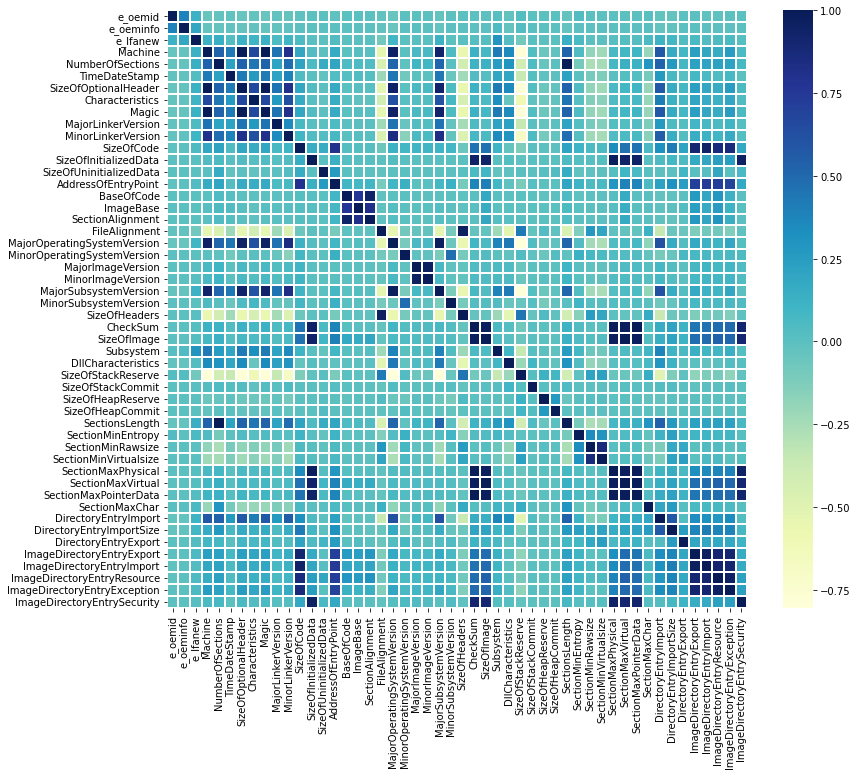

In [5]:
corrMatrix = X.corr()
correlated_features = set()
for i in range(len(corrMatrix .columns)):
    for j in range(i):
        if abs(corrMatrix.iloc[i, j]) > 0.8:
            colname = corrMatrix.columns[i]
            correlated_features.add(colname)

len(correlated_features)
f, ax = plt.subplots(figsize =(13, 11))
sns.heatmap(corrMatrix, ax = ax, cmap ="YlGnBu", linewidths = 0.1)

Construimos el conjunto de datos sin balanceo

In [6]:
resample="" #"-u" -> aplicar undersampling    "-o" -> aplicar oversampling    "" -> no aplica ningun resampling

X,y = buildDataset(resample, drop)
X.drop(labels=correlated_features, axis=1, inplace=True)
X_train, X_test, y_train, y_test = trainTest(X, y)
display(pd.DataFrame(features, columns=["Características"]))

,e_oemid,e_oeminfo,e_lfanew,Machine,NumberOfSections,TimeDateStamp,SizeOfOptionalHeader,Characteristics,Magic,MajorLinkerVersion,MinorLinkerVersion,SizeOfCode,SizeOfInitializedData,SizeOfUninitializedData,AddressOfEntryPoint,BaseOfCode,ImageBase,SectionAlignment,FileAlignment,MajorOperatingSystemVersion,MinorOperatingSystemVersion,MajorImageVersion,MinorImageVersion,MajorSubsystemVersion,MinorSubsystemVersion,SizeOfHeaders,CheckSum,SizeOfImage,Subsystem,DllCharacteristics,SizeOfStackReserve,SizeOfStackCommit,SizeOfHeapReserve,SizeOfHeapCommit,SectionsLength,SectionMinEntropy,SectionMinRawsize,SectionMinVirtualsize,SectionMaxPhysical,SectionMaxVirtual,SectionMaxPointerData,SectionMaxChar,DirectoryEntryImport,DirectoryEntryImportSize,DirectoryEntryExport,ImageDirectoryEntryExport,ImageDirectoryEntryImport,ImageDirectoryEntryResource,ImageDirectoryEntryException,ImageDirectoryEntrySecurity
0,0,0,208,34404,3,862303488,240,8226,523,14,20,0,2560,0,0,4096,6.442451e+09,4096,512,10,0,10,0,10,0,1024,22314,16384,3,352,262144,4096,1048576,4096,3,1.109908,512,172,1216,12288,2048,1073741888,0,0,0,4192,0,12288,0,3584
1,0,0,208,34404,3,868140066,240,8226,523,14,20,0,2560,0,0,4096,6.442451e+09,4096,512,10,0,10,0,10,0,1024,60113,16384,3,352,262144,4096,1048576,4096,3,1.065603,512,164,1232,12288,2048,1073741888,0,0,0,4192,0,12288,0,3584
2,0,0,240,34404,7,2970139665,240,8226,523,14,20,302080,159744,0,285008,4096,6.442451e+09,4096,512,10,0,10,0,10,0,1024,508596,483328,3,16736,262144,4096,1048576,4096,7,1.457743,512,416,301771,479232,458752,3221225536,37,211,10,438464,438888,475136,458752,0
3,0,0,256,34404,7,1413445865,240,8226,523,14,20,685056,310784,0,661360,4096,6.442451e+09,4096,512,10,0,10,0,10,0,1024,1051565,1015808,3,16864,262144,4096,1048576,4096,7,1.793641,1024,672,684736,1011712,991744,3221225536,44,270,3,940080,940228,983040,958464,0
4,0,0,240,34404,6,4027921771,240,8226,523,14,20,65024,34816,0,63680,4096,6.442451e+09,4096,512,10,0,10,0,10,0,1024,140241,114688,3,16736,262144,4096,1048576,4096,6,3.213580,1024,552,64823,110592,97280,3221225536,25,110,1,89088,89168,106496,102400,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91170,0,0,192,332,3,1076535155,224,271,267,6,0,16384,8192,0,5104,4096,4.194304e+06,4096,4096,4,0,1,0,4,0,4096,36398,28672,2,0,1048576,4096,1048576,4096,3,0.000000,4096,2248,12404,24576,24576,3221225536,1,80,0,0,15012,24576,0,0
91171,0,0,176,332,3,1294482234,224,271,267,6,0,245760,16384,0,4564,4096,4.194304e+06,4096,4096,4,0,1,0,4,0,4096,303086,266240,2,0,1048576,4096,1048576,4096,3,0.000000,0,5196,243096,258048,249856,3221225536,1,46,0,0,246820,258048,0,0
91172,0,0,184,332,3,1222947799,224,271,267,6,0,20480,8192,0,5116,4096,4.194304e+06,4096,4096,4,0,1,0,4,0,4096,80279,32768,2,0,1048576,4096,1048576,4096,3,0.000000,4096,1824,19260,28672,28672,3221225536,1,79,0,0,21796,28672,0,0
91173,0,0,208,332,9,1091599181,224,270,267,7,10,83840,10624,0,91028,896,6.553600e+04,128,128,5,1,5,1,5,1,896,152442,95360,1,0,262144,4096,1048576,4096,9,0.443660,1024,1008,38514,92032,92032,3791650848,3,121,0,0,87616,91008,0,0


Número de muestras totales: 91175 



Número de características usadas: 28 





,Características
0,e_oemid
1,e_oeminfo
2,e_lfanew
3,Machine
4,NumberOfSections
5,TimeDateStamp
6,Characteristics
7,MajorLinkerVersion
8,SizeOfCode
9,SizeOfInitializedData


Entrenamos los modelos sin balanceo

In [7]:
train_and_CV(X_train, y_train)

VALIDACIÓN CRUZADA
LR: 0.999644 (0.000186) (0.455459s)
KNN9: 0.999657 (0.000189) (0.010000s)
KNN7: 0.999657 (0.000208) (0.008943s)
KNN5: 0.999671 (0.000196) (0.012000s)
KNN3: 0.999616 (0.000335) (0.011043s)
KNN1: 0.999685 (0.000215) (0.010018s)
RF: 0.999904 (0.000070) (3.359674s)
CART: 0.999808 (0.000186) (0.156068s)
NB: 0.998081 (0.000477) (0.039000s)
SVM: 0.999589 (0.000179) (2.350426s)


Comparamos los resultados de los modelos sin balanceo

In [ ]:
compareMLAs(X_train, X_test, y_train, y_test)

Construimos el conjunto de datos con submuestreo

In [ ]:
resample="-u" #"-u" -> aplicar undersampling    "-o" -> aplicar oversampling    "" -> no aplica ningun resampling

X,y = buildDataset(resample, drop)
X.drop(labels=correlated_features, axis=1, inplace=True)
X_train, X_test, y_train, y_test = trainTest(X, y)
display(pd.DataFrame(features, columns=["Características"]))

Entrenamos los modelos con submuestreo

In [ ]:
train_and_CV(X_train, y_train)

Comparamos los resultados de los modelos con submuestreo

In [ ]:
compareMLAs(X_train, X_test, y_train, y_test)

Construimos el conjunto de datos con sobremuestreo

In [ ]:
resample="-o" #"-u" -> aplicar undersampling    "-o" -> aplicar oversampling    "" -> no aplica ningun resampling

X,y = buildDataset(resample, drop)
X.drop(labels=correlated_features, axis=1, inplace=True)
X_train, X_test, y_train, y_test = trainTest(X, y)
display(pd.DataFrame(features, columns=["Características"]))

Entrenamos los modelos con sobremuestreo

In [ ]:
train_and_CV(X_train, y_train)

Comparamos los resultados de los modelos con sobremuestreo

In [ ]:
compareMLAs(X_train, X_test, y_train, y_test)